### Getting the data

In [1]:
import datetime as dt
import pandas_datareader as pdr
import numpy as np
import pandas as pd

In [2]:
ticker = 'FB'

trainStart = dt.datetime(2015,1,1)
trainEnd = dt.datetime(2020,1,1)

data = pdr.DataReader(ticker, 'yahoo', trainStart, trainEnd)
data.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2015-01-02,78.930000,77.699997,78.580002,78.449997,18177500,78.449997
2015-01-05,79.250000,76.860001,77.980003,77.190002,26452200,77.190002
2015-01-06,77.589996,75.360001,77.230003,76.150002,27399300,76.150002
2015-01-07,77.360001,75.820000,76.760002,76.150002,22045300,76.150002
2015-01-08,78.230003,76.080002,76.739998,78.180000,23961000,78.180000


### Preparing the data

In [3]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data['Adj Close'].values.reshape(-1,1))

In [4]:
prediction_period = 60 #(in days)

x_train = []
y_train = []

for x in range(prediction_period, len(scaled_data)):
    x_train.append(scaled_data[x-prediction_period:x, 0])
    y_train.append(scaled_data[x,0])

In [5]:
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

### Building the Model

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM


model = Sequential()

model.add(LSTM(units = 50, return_sequences = True, input_shape=(x_train.shape[1],1)))
model.add(Dropout(0.2))

model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units = 50))
model.add(Dropout(0.2))

model.add(Dense(units=1)) 

In [7]:
model.compile(optimizer='adam', loss = 'mean_squared_error')
model.fit(x_train, y_train, epochs=25, batch_size=32)

Epoch 1/25
38/38 [==============================] - 5s 31ms/step - loss: 0.0919
Epoch 2/25
38/38 [==============================] - 1s 31ms/step - loss: 0.0066
Epoch 3/25
38/38 [==============================] - 1s 31ms/step - loss: 0.0060
Epoch 4/25
38/38 [==============================] - 1s 31ms/step - loss: 0.0052: 0s - loss: 0.0
Epoch 5/25
38/38 [==============================] - 1s 31ms/step - loss: 0.0065
Epoch 6/25
38/38 [==============================] - 1s 31ms/step - loss: 0.0053
Epoch 7/25
38/38 [==============================] - 1s 32ms/step - loss: 0.0049
Epoch 8/25
38/38 [==============================] - 1s 31ms/step - loss: 0.0046
Epoch 9/25
38/38 [==============================] - 1s 31ms/step - loss: 0.0045
Epoch 10/25
38/38 [==============================] - 1s 31ms/step - loss: 0.0042
Epoch 11/25
38/38 [==============================] - 1s 31ms/step - loss: 0.0042
Epoch 12/25
38/38 [==============================] - 1s 32ms/step - loss: 0.0047
Epoch 13/25
38/38 [==

### Testing the model

In [8]:
testStart = dt.datetime(2020,1,1)
testEnd = dt.datetime.now()

test_data = pdr.DataReader(ticker, 'yahoo', testStart, testEnd)
test_data.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2020-01-02,209.789993,206.270004,206.750000,209.779999,12077100,209.779999
2020-01-03,210.399994,206.949997,207.210007,208.669998,11188400,208.669998
2020-01-06,212.779999,206.520004,206.699997,212.600006,17058900,212.600006
2020-01-07,214.580002,211.750000,212.820007,213.059998,14912400,213.059998
2020-01-08,216.240005,212.610001,213.000000,215.220001,13475000,215.220001


In [9]:
actual_prices = test_data['Adj Close'].values

total_dataset = pd.concat((data['Adj Close'],test_data['Adj Close'] ), axis=0)
model_inputs = total_dataset[len(total_dataset)- len(test_data) - prediction_period:].values
model_inputs = model_inputs.reshape(-1,1)
model_inputs = scaler.transform(model_inputs)

##### Making Predictions on Test Data

In [10]:
x_test = []

for x in range(prediction_period, len(model_inputs)):
    x_test.append(model_inputs[x-prediction_period:x, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1],1))

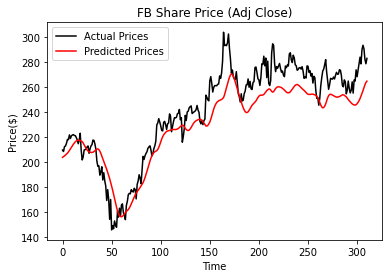

In [11]:
import matplotlib.pyplot as plt
pred_prices = model.predict(x_test)
pred_prices = scaler.inverse_transform(pred_prices)

plt.plot(actual_prices, color='black', label='Actual Prices')
plt.plot(pred_prices, color='red', label='Predicted Prices')
plt.title(f"{ticker} Share Price (Adj Close)")
plt.xlabel('Time')
plt.ylabel('Price($)')
plt.legend()
plt.show()

### Predicting Next Day

In [15]:
real_data = [model_inputs[len(model_inputs)+ 1 - prediction_period: len(model_inputs+1),0]]
real_data = np.array(real_data)
real_data = np.reshape(real_data, (real_data.shape[0], real_data.shape[1],1))

pred = model.predict(real_data)
pred = scaler.inverse_transform(pred)
print(f"Prediction: {pred}")

Prediction: [[265.3315]]
